In [ ]:
def create_batch_image(img):

    img = tf.expand_dims(img ,axis=0)
    return (img)

In [93]:
import tensorflow as tf
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import time
import cv2
import os
import requests
import IPython.display as display
import PIL.Image

from cv2 import cvtColor
from cv2 import imread
from cv2 import COLOR_BGR2RGB

from keras import Model
from keras.preprocessing.image import load_img, img_to_array
from os import listdir
from keras import Sequential

from data import Data_Augmentation
from model import Create_transfert_learning_Model
from constant import IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_COLOR

In [94]:
def normalize_img(img):
    
    img = img / 255.
    return (img)

def load_image(path):

    img = load_img(path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    # img = cvtColor(img, COLOR_BGR2RGB)
    img = img_to_array(img)
    # img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    img = normalize_img(img)

    return (img)

def open_all_img_directory(directory : str, classe : int) :

  dataset = list()
  for filename in listdir(directory):

    path = directory + '/' + filename
    img = load_image(path)
    # print('loaded %s' % filename)
    dataset.append((img, classe))

  return (dataset)

def create_X_Y(dataset : list):
    
    X = list()
    Y = list()
    
    for data in dataset :
        X.append(data[0])
        Y.append(data[1])

    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape(Y.shape[0], 1)
    
    return (X, Y)

def open_dataset(dir_1 : str, dir_2 : str):

    disease_images = open_all_img_directory(dir_1, 1)
    healthy_images = open_all_img_directory(dir_2, 0)

    return (disease_images, healthy_images)

In [95]:
disease_images, healthy_images = open_dataset('leaves_img/malade', 'leaves_img/sain')
X_disease, Y_disease = create_X_Y(disease_images)
X_healthy, Y_healthy = create_X_Y(healthy_images)

print(X_disease.shape, Y_disease.shape)
print(X_healthy.shape, Y_healthy.shape)

(85, 224, 224, 3) (85, 1)
(96, 224, 224, 3) (96, 1)


(-0.5, 223.5, 223.5, -0.5)

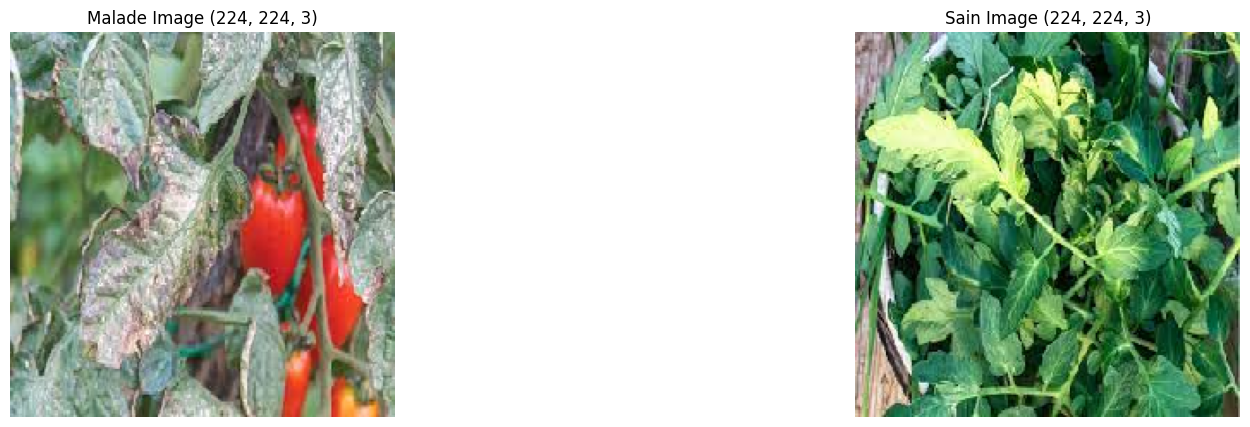

In [96]:
malade = X_disease[0]
sain = X_healthy[0]

# image = np.reshape(malade, (malade.shape[3], malade.shape[1], malade.shape[2]))
# plt.imshow(image)
# # print(malade)
#
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].imshow(malade)
ax[0].title.set_text(f'Malade Image {malade.shape}')
ax[0].axis('off')

ax[1].imshow(sain)
ax[1].title.set_text(f'Sain Image {sain.shape}')
ax[1].axis('off')

In [97]:
Augmentator = Data_Augmentation(6)
img = X_disease[0]
augmented_images = Augmentator(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


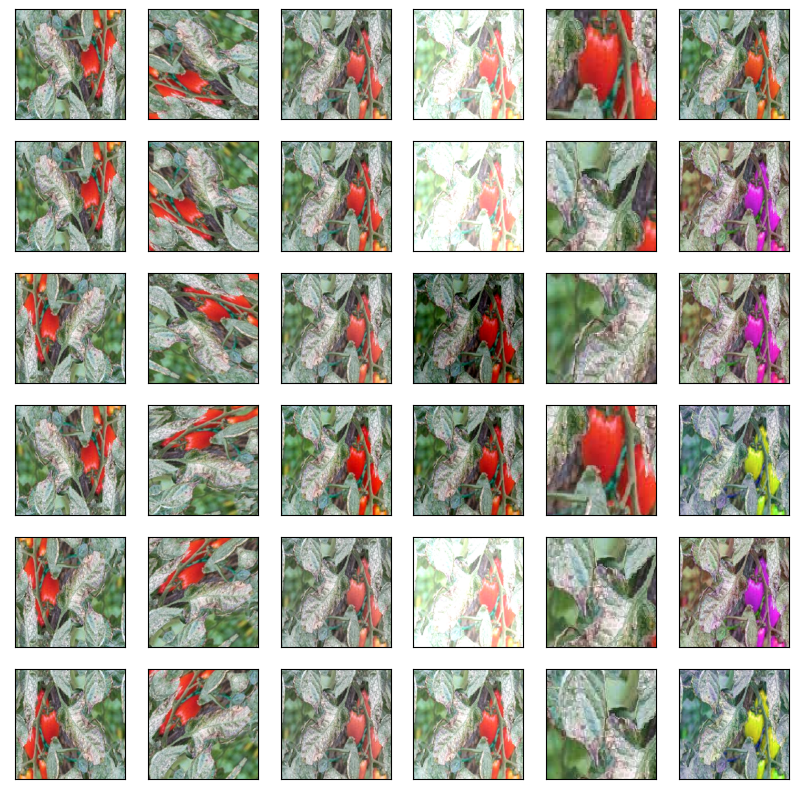

In [98]:
height = 6
width = 6

fig = plt.figure(figsize= (10, 10))
for i in range (len(augmented_images)):
    ax = fig.add_subplot(height, width, i+1)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.imshow(augmented_images[i])

In [ ]:
model = Create_transfert_learning_Model(3)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   